# ADS Nutritional Label: Costa Rican Household Poverty Prediction

Sabina Prochowski & Meghana Kakubal

Contents:


*   **ADS Code** - Kaggle user Gaxx's pre-processing and implementation
* --> Outlier
* --> Missing Value
* --> Feature Engineering
* --> Model LightGBM
*   **Input & Output** - our analysis of the ADS's input and output
*   **Implementation & Validation** - our analysis
*  **Outcomes** - our analysis



TO RUN THE NOTEBOOK: Upload the 'train.csv' and 'test.csv' files to the Colab session




# ADS Code

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colors are set!')

from sklearn.model_selection import StratifiedKFold
print('sklearn imported!')

import lightgbm as lgb
print('lightgbm imported!')

My colors are set!
sklearn imported!
lightgbm imported!


In [ ]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

print(f'train set has {train_set.shape[0]} rows, and {train_set.shape[1]} features')
print(f'test set has {test_set.shape[0]} rows, and {test_set.shape[1]} features')

train set has 9557 rows, and 143 features
test set has 23856 rows, and 142 features


In [ ]:
#Let's take a look at target
target = train_set['Target']
target.value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

## Outlier

I had a look into train and test set, it turned out there is only one outlier value **rez_esc** in test set, and acorrding to the answer from competition host(https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), we can safely change the value to 5

In [ ]:
#outlier in test set which rez_esc is 99.0
test_set.loc[test_set['rez_esc'] == 99.0 , 'rez_esc'] = 5

## Missing Value

In [ ]:
data_na = train_set.isnull().sum().values / train_set.shape[0] *100
df_na = pd.DataFrame(data_na, index=train_set.columns, columns=['Count'])
df_na = df_na.sort_values(by=['Count'], ascending=False)

missing_value_count = df_na[df_na['Count']>0].shape[0]

print(f'We got {missing_value_count} rows which have missing value in train set ')
df_na.head(6)

We got 5 rows which have missing value in train set 


,Count
rez_esc,82.954902
v18q1,76.823271
v2a1,71.779847
SQBmeaned,0.052318
meaneduc,0.052318
Id,0.000000


*  **rez_esc** represents "years behind in school", missing value could be filled as 0
*  **meaneduc** represents "average years of education for adults (18+)", missing value could be filled as 0
*  **v18q1** really depends on v18q
*  **v2a1** depends on tipovivi3

We do not really need SQBxxxx features for polynomial in our case, and i will use fillna as 0 after at the last step of feature engineering

In [ ]:
data_na = test_set.isnull().sum().values / test_set.shape[0] *100
df_na = pd.DataFrame(data_na, index=test_set.columns, columns=['Count'])
df_na = df_na.sort_values(by=['Count'], ascending=False)

missing_value_count = df_na[df_na['Count']>0].shape[0]

print(f'We got {missing_value_count} rows which have missing value in test set ')
df_na.head(6)

We got 5 rows which have missing value in test set 


,Count
rez_esc,82.381791
v18q1,75.980885
v2a1,72.950201
meaneduc,0.129946
SQBmeaned,0.129946
instlevel1,0.000000


In [ ]:
#Fill na
def repalce_v18q1(x):
    if x['v18q'] == 0:
        return x['v18q']
    else:
        return x['v18q1']

train_set['v18q1'] = train_set.apply(lambda x : repalce_v18q1(x),axis=1)
test_set['v18q1'] = test_set.apply(lambda x : repalce_v18q1(x),axis=1)

train_set['v2a1'] = train_set['v2a1'].fillna(value=train_set['tipovivi3'])
test_set['v2a1'] = test_set['v2a1'].fillna(value=test_set['tipovivi3'])

## Feature Engineering

Replace object value, because some labels were generated whenever continuous variables have 1 or 0. The rule is to have being 1 yes=1 and no=0

In [ ]:
cols = ['edjefe', 'edjefa']
train_set[cols] = train_set[cols].replace({'no': 0, 'yes':1}).astype(float)
test_set[cols] = test_set[cols].replace({'no': 0, 'yes':1}).astype(float)

It turns out orignial data lost one feature both for **roof** and **electricity**, so we manually add new feature

In [ ]:
train_set['roof_waste_material'] = np.nan
test_set['roof_waste_material'] = np.nan
train_set['electricity_other'] = np.nan
test_set['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

train_set['roof_waste_material'] = train_set.apply(lambda x : fill_roof_exception(x),axis=1)
test_set['roof_waste_material'] = test_set.apply(lambda x : fill_roof_exception(x),axis=1)
train_set['electricity_other'] = train_set.apply(lambda x : fill_no_electricity(x),axis=1)
test_set['electricity_other'] = test_set.apply(lambda x : fill_no_electricity(x),axis=1)

In [ ]:
def owner_is_adult(x):
    if x['age'] <= 18:
        return 0
    else:
        return 1

train_set['head<18'] = train_set.apply(lambda x : owner_is_adult(x),axis=1)
test_set['head<18'] = test_set.apply(lambda x : owner_is_adult(x),axis=1)

More feature engineering 

In [ ]:
train_set['adult'] = train_set['hogar_adul'] - train_set['hogar_mayor']
train_set['dependency_count'] = train_set['hogar_nin'] + train_set['hogar_mayor']
train_set['dependency'] = train_set['dependency_count'] / train_set['adult']
train_set['child_percent'] = train_set['hogar_nin']/train_set['hogar_total']
train_set['elder_percent'] = train_set['hogar_mayor']/train_set['hogar_total']
train_set['adult_percent'] = train_set['hogar_adul']/train_set['hogar_total']
test_set['adult'] = test_set['hogar_adul'] - test_set['hogar_mayor']
test_set['dependency_count'] = test_set['hogar_nin'] + test_set['hogar_mayor']
test_set['dependency'] = test_set['dependency_count'] / test_set['adult']
test_set['child_percent'] = test_set['hogar_nin']/test_set['hogar_total']
test_set['elder_percent'] = test_set['hogar_mayor']/test_set['hogar_total']
test_set['adult_percent'] = test_set['hogar_adul']/test_set['hogar_total']

train_set['rent_per_adult'] = train_set['v2a1']/train_set['hogar_adul']
train_set['rent_per_person'] = train_set['v2a1']/train_set['hhsize']
test_set['rent_per_adult'] = test_set['v2a1']/test_set['hogar_adul']
test_set['rent_per_person'] = test_set['v2a1']/test_set['hhsize']

train_set['overcrowding_room_and_bedroom'] = (train_set['hacdor'] + train_set['hacapo'])/2
test_set['overcrowding_room_and_bedroom'] = (test_set['hacdor'] + test_set['hacapo'])/2

train_set['no_appliances'] = train_set['refrig'] + train_set['computer'] + train_set['television']
test_set['no_appliances'] = test_set['refrig'] + test_set['computer'] + test_set['television']

train_set['r4h1_percent_in_male'] = train_set['r4h1'] / train_set['r4h3']
train_set['r4m1_percent_in_female'] = train_set['r4m1'] / train_set['r4m3']
train_set['r4h1_percent_in_total'] = train_set['r4h1'] / train_set['hhsize']
train_set['r4m1_percent_in_total'] = train_set['r4m1'] / train_set['hhsize']
train_set['r4t1_percent_in_total'] = train_set['r4t1'] / train_set['hhsize']
test_set['r4h1_percent_in_male'] = test_set['r4h1'] / test_set['r4h3']
test_set['r4m1_percent_in_female'] = test_set['r4m1'] / test_set['r4m3']
test_set['r4h1_percent_in_total'] = test_set['r4h1'] / test_set['hhsize']
test_set['r4m1_percent_in_total'] = test_set['r4m1'] / test_set['hhsize']
test_set['r4t1_percent_in_total'] = test_set['r4t1'] / test_set['hhsize']

train_set['rent_per_room'] = train_set['v2a1']/train_set['rooms']
train_set['bedroom_per_room'] = train_set['bedrooms']/train_set['rooms']
train_set['elder_per_room'] = train_set['hogar_mayor']/train_set['rooms']
train_set['adults_per_room'] = train_set['adult']/train_set['rooms']
train_set['child_per_room'] = train_set['hogar_nin']/train_set['rooms']
train_set['male_per_room'] = train_set['r4h3']/train_set['rooms']
train_set['female_per_room'] = train_set['r4m3']/train_set['rooms']
train_set['room_per_person_household'] = train_set['hhsize']/train_set['rooms']

test_set['rent_per_room'] = test_set['v2a1']/test_set['rooms']
test_set['bedroom_per_room'] = test_set['bedrooms']/test_set['rooms']
test_set['elder_per_room'] = test_set['hogar_mayor']/test_set['rooms']
test_set['adults_per_room'] = test_set['adult']/test_set['rooms']
test_set['child_per_room'] = test_set['hogar_nin']/test_set['rooms']
test_set['male_per_room'] = test_set['r4h3']/test_set['rooms']
test_set['female_per_room'] = test_set['r4m3']/test_set['rooms']
test_set['room_per_person_household'] = test_set['hhsize']/test_set['rooms']

train_set['rent_per_bedroom'] = train_set['v2a1']/train_set['bedrooms']
train_set['edler_per_bedroom'] = train_set['hogar_mayor']/train_set['bedrooms']
train_set['adults_per_bedroom'] = train_set['adult']/train_set['bedrooms']
train_set['child_per_bedroom'] = train_set['hogar_nin']/train_set['bedrooms']
train_set['male_per_bedroom'] = train_set['r4h3']/train_set['bedrooms']
train_set['female_per_bedroom'] = train_set['r4m3']/train_set['bedrooms']
train_set['bedrooms_per_person_household'] = train_set['hhsize']/train_set['bedrooms']

test_set['rent_per_bedroom'] = test_set['v2a1']/test_set['bedrooms']
test_set['edler_per_bedroom'] = test_set['hogar_mayor']/test_set['bedrooms']
test_set['adults_per_bedroom'] = test_set['adult']/test_set['bedrooms']
test_set['child_per_bedroom'] = test_set['hogar_nin']/test_set['bedrooms']
test_set['male_per_bedroom'] = test_set['r4h3']/test_set['bedrooms']
test_set['female_per_bedroom'] = test_set['r4m3']/test_set['bedrooms']
test_set['bedrooms_per_person_household'] = test_set['hhsize']/test_set['bedrooms']

train_set['tablet_per_person_household'] = train_set['v18q1']/train_set['hhsize']
train_set['phone_per_person_household'] = train_set['qmobilephone']/train_set['hhsize']
test_set['tablet_per_person_household'] = test_set['v18q1']/test_set['hhsize']
test_set['phone_per_person_household'] = test_set['qmobilephone']/test_set['hhsize']

train_set['age_12_19'] = train_set['hogar_nin'] - train_set['r4t1']
test_set['age_12_19'] = test_set['hogar_nin'] - test_set['r4t1']    

train_set['escolari_age'] = train_set['escolari']/train_set['age']
test_set['escolari_age'] = test_set['escolari']/test_set['age']

train_set['rez_esc_escolari'] = train_set['rez_esc']/train_set['escolari']
train_set['rez_esc_r4t1'] = train_set['rez_esc']/train_set['r4t1']
train_set['rez_esc_r4t2'] = train_set['rez_esc']/train_set['r4t2']
train_set['rez_esc_r4t3'] = train_set['rez_esc']/train_set['r4t3']
train_set['rez_esc_age'] = train_set['rez_esc']/train_set['age']
test_set['rez_esc_escolari'] = test_set['rez_esc']/test_set['escolari']
test_set['rez_esc_r4t1'] = test_set['rez_esc']/test_set['r4t1']
test_set['rez_esc_r4t2'] = test_set['rez_esc']/test_set['r4t2']
test_set['rez_esc_r4t3'] = test_set['rez_esc']/test_set['r4t3']
test_set['rez_esc_age'] = test_set['rez_esc']/test_set['age']

In [ ]:
train_set['dependency'] = train_set['dependency'].replace({np.inf: 0})
test_set['dependency'] = test_set['dependency'].replace({np.inf: 0})

print(f'train set has {train_set.shape[0]} rows, and {train_set.shape[1]} features')
print(f'test set has {test_set.shape[0]} rows, and {test_set.shape[1]} features')

train set has 9557 rows, and 184 features
test set has 23856 rows, and 183 features


In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

aggr_mean_list = ['rez_esc', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco2',
             'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
             'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',]

other_list = ['escolari', 'age', 'escolari_age']

for item in aggr_mean_list:
    group_train_mean = train_set[item].groupby(train_set['idhogar']).mean()
    group_test_mean = test_set[item].groupby(test_set['idhogar']).mean()
    new_col = item + '_aggr_mean'
    df_train[new_col] = group_train_mean
    df_test[new_col] = group_test_mean

for item in other_list:
    for function in ['mean','std','min','max','sum']:
        group_train = train_set[item].groupby(train_set['idhogar']).agg(function)
        group_test = test_set[item].groupby(test_set['idhogar']).agg(function)
        new_col = item + '_' + function
        df_train[new_col] = group_train
        df_test[new_col] = group_test

print(f'new aggregate train set has {df_train.shape[0]} rows, and {df_train.shape[1]} features')
print(f'new aggregate test set has {df_test.shape[0]} rows, and {df_test.shape[1]} features')

new aggregate train set has 2988 rows, and 46 features
new aggregate test set has 7352 rows, and 46 features


In [ ]:
df_test = df_test.reset_index()
df_train = df_train.reset_index()

train_agg = pd.merge(train_set, df_train, on='idhogar')
test = pd.merge(test_set, df_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)
print(f'new train set has {train_agg.shape[0]} rows, and {train_agg.shape[1]} features')
print(f'new test set has {test.shape[0]} rows, and {test.shape[1]} features')

new train set has 9557 rows, and 230 features
new test set has 23856 rows, and 229 features


In [ ]:
#According to data descriptions,ONLY the heads of household are used in scoring. /
#All household members are included in test + the sample submission, but only heads of households are scored.
train = train_agg.query('parentesco1==1')

In [ ]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positive feature: \n{correlation.head(20)}')
print('*'*50)

print(f'The most 20 negative feature: \n{correlation.tail(20)}')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The most 20 positive feature: 
Target                  1.000000
escolari_mean           0.423626
escolari_max            0.373091
escolari                0.333791
meaneduc                0.331489
escolari_min            0.306693
cielorazo               0.295249
eviv3                   0.293540
instlevel8_aggr_mean    0.293307
epared3                 0.280947
escolari_age_min        0.276896
pisomoscer              0.275452
adult_percent           0.263882
etecho3                 0.261142
escolari_age_mean       0.258934
escolari_sum            0.256726
paredblolad             0.254469
edjefe                  0.235687
instlevel8              0.235102
escolari_age            0.232205
Name: Target, dtype: float64
**************************************************
The most 20 negative feature: 
child_percent       -0.263882
hogar_nin           -0.266309
dependency_count    -0.283908
dependency          -0.304563
child_per_room      -0.305541
child_per_bedroom   -0.308308
elimbasu5         

In [ ]:
test.to_csv('processed_test.csv', index=False)

## Model - LightGBM 
Parameter values are just copied from [Misha Lisovyi](https://www.kaggle.com/mlisovyi/lighgbm-hyperoptimisation-with-f1-macro) for now

In [ ]:
y = train['Target']

train.drop(columns=['Target'], inplace=True)

#parameter value is copied from 
clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 95, num_leaves = 14, subsample = 0.96)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

predicts_result = []
for train_index, test_index in kf.split(train, y):
    print("###")
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=400, verbose=100, eval_metric  = 'logloss',)
    predicts_result.append(clf.predict(test))

###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.991555
[200]	valid_0's multi_logloss: 1.01184
[300]	valid_0's multi_logloss: 1.06132
[400]	valid_0's multi_logloss: 1.1317
[500]	valid_0's multi_logloss: 1.20431
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.988183
###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.996859
[200]	valid_0's multi_logloss: 0.995177
[300]	valid_0's multi_logloss: 1.03341
[400]	valid_0's multi_logloss: 1.08048
[500]	valid_0's multi_logloss: 1.13648
Early stopping, best iteration is:
[151]	valid_0's multi_logloss: 0.985308
###
Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.974351
[200]	valid_0's multi_logloss: 0.977767
[300]	valid_0's multi_logloss: 1.01453
[400]	valid_0's multi_logloss: 1.07598
[500]	valid_0's multi_logloss: 1.14429
Early stopping, best iteration is:
[149]	valid_0's multi_log

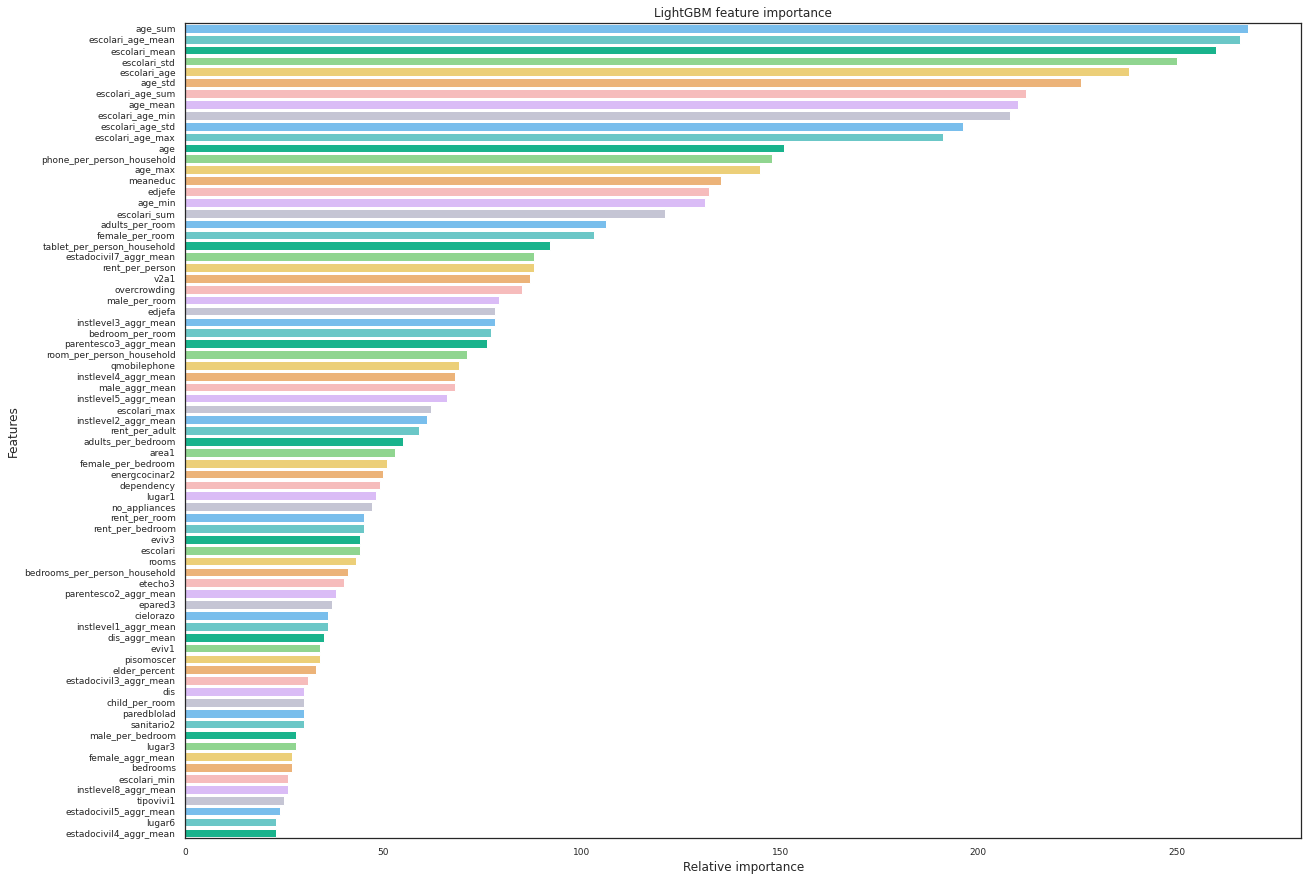

In [ ]:
indices = np.argsort(clf.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = clf.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("LightGBM feature importance");

In [ ]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission.csv', index = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Input & Output

In [ ]:
train_set = pd.read_csv('train.csv')
train_set

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.00,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.00,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.00,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.00,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.00,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,NaN,0,2,2,1,2,3,1,4,5,5,5,9,NaN,5,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,d6c086aa3,1,4,0,5,.25,9,

In [ ]:
test_set = pd.read_csv('test.csv')
test_set

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.50,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.2500,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.50,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.2500,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.50,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.2500,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.00,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.0000,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23851,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,2,2,1,3,4,1,5,6,6,6,3,0.0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3aa78c56b,2,4,0,6,.5,5,no,5.75,0,1,0,0,0,0,0,0,0,1,6.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,10,9,100,36,25,4,36.00,0.25,33.0625,100
23852,ID_1a

In [ ]:
# finds data types of all columns
train_set.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 143 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Id               object 
 1    v2a1             float64
 2    hacdor           int64  
 3    rooms            int64  
 4    hacapo           int64  
 5    v14a             int64  
 6    refrig           int64  
 7    v18q             int64  
 8    v18q1            float64
 9    r4h1             int64  
 10   r4h2             int64  
 11   r4h3             int64  
 12   r4m1             int64  
 13   r4m2             int64  
 14   r4m3             int64  
 15   r4t1             int64  
 16   r4t2             int64  
 17   r4t3             int64  
 18   tamhog           int64  
 19   tamviv           int64  
 20   escolari         int64  
 21   rez_esc          float64
 22   hhsize           int64  
 23   paredblolad      int64  
 24   paredzocalo      int64  
 25   paredpreb        int64  
 26   pareddes         i

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85944fa510>,
      dtype=object)

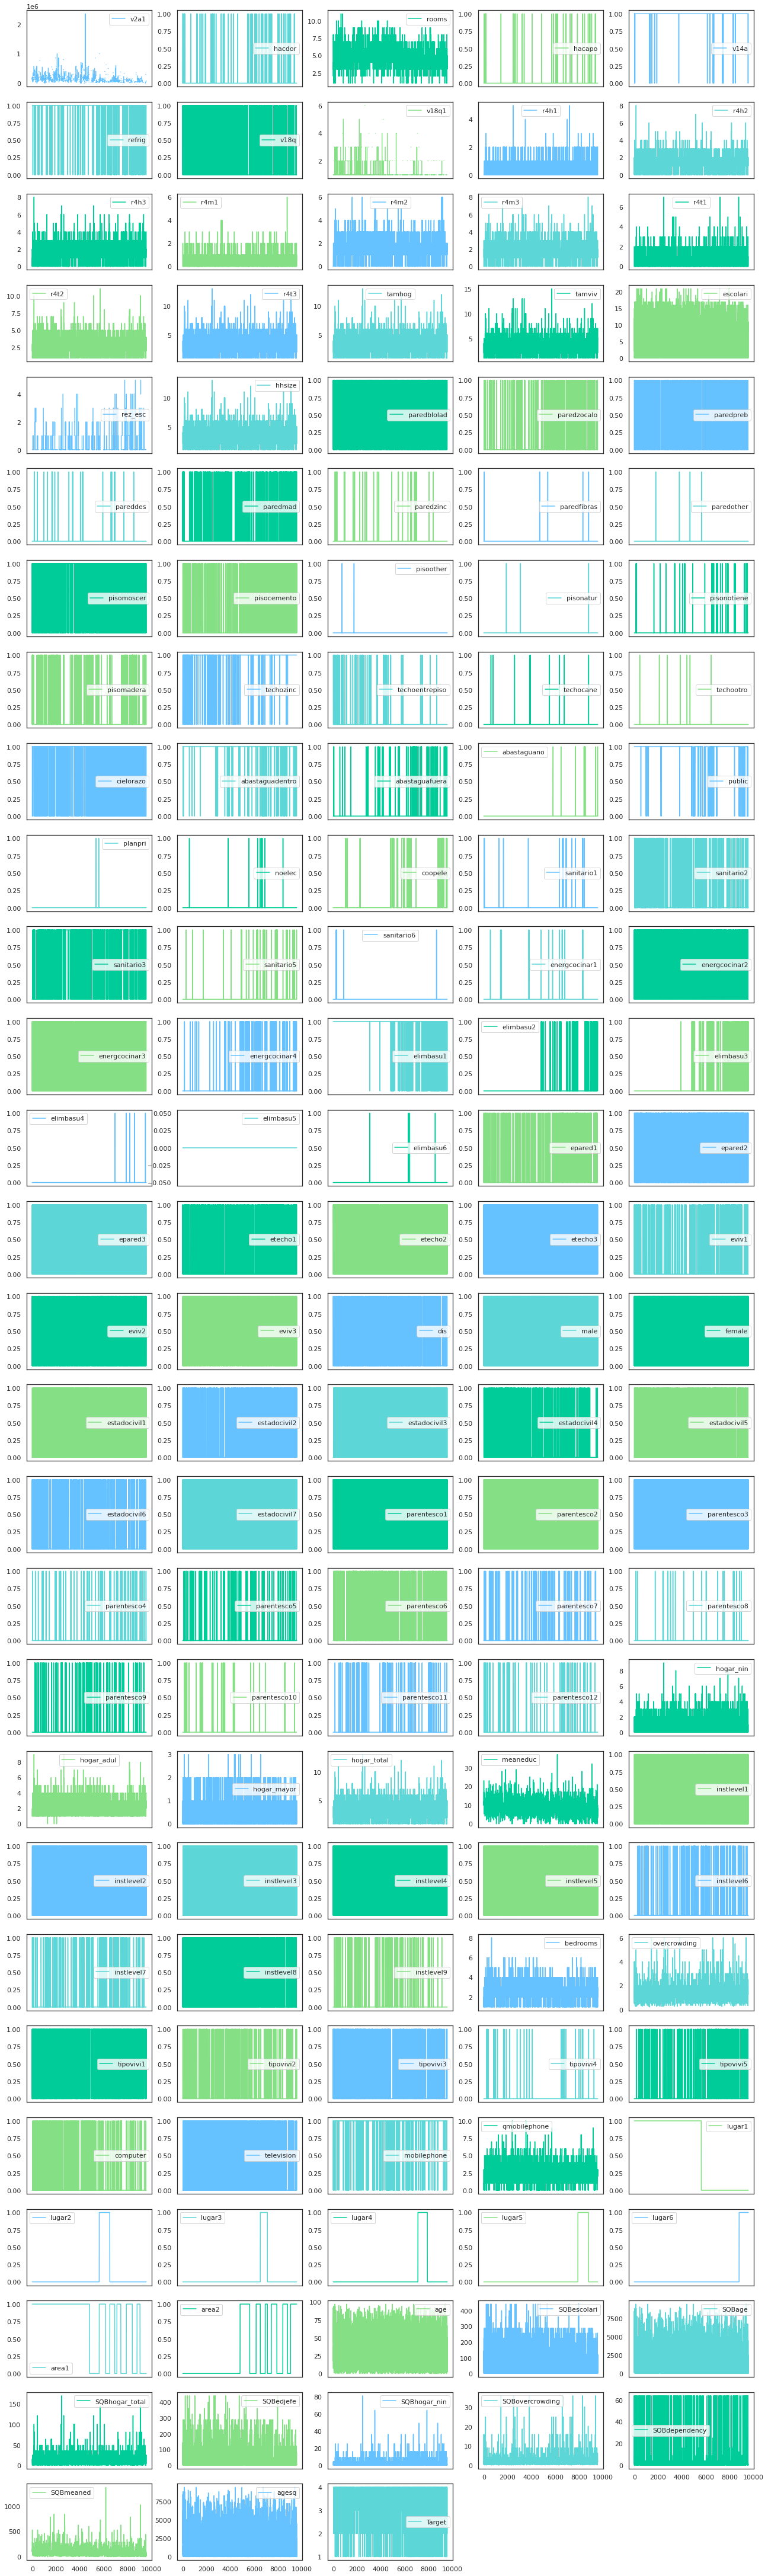

In [ ]:
# value distribution of all input vars
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set.plot(subplots=True, layout=(29,5), figsize=(22,82)) # for 143 cols

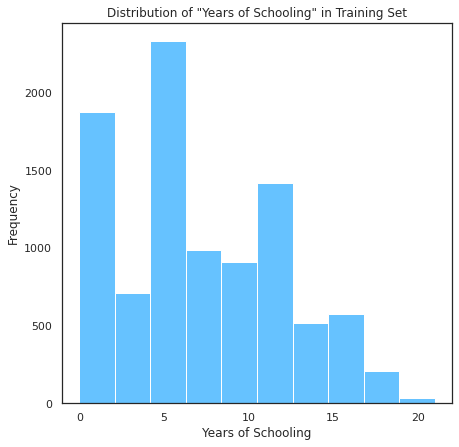

In [ ]:
# escolari (years of schooling) distribution
fig,ax = plt.subplots(figsize = (7,7))
ax.hist(train_set['escolari'])
plt.xlabel('Years of Schooling')
plt.ylabel('Frequency')
plt.title('Distribution of "Years of Schooling" in Training Set')
plt.show()

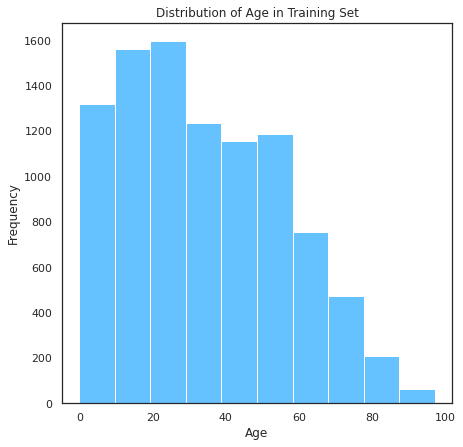

In [ ]:
# age distribution
fig,ax = plt.subplots(figsize = (7,7))
ax.hist(train_set['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Training Set')
plt.show()

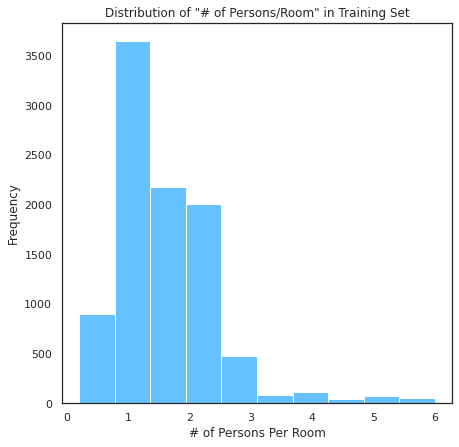

In [ ]:
# overcrowding distribution
fig,ax = plt.subplots(figsize = (7,7))
ax.hist(train_set['overcrowding'])
plt.xlabel('# of Persons Per Room')
plt.ylabel('Frequency')
plt.title('Distribution of "# of Persons/Room" in Training Set')
plt.show()

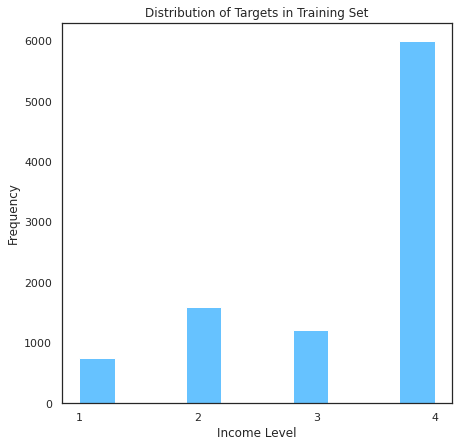

In [ ]:
# distribution of target in training set
fig, ax = plt.subplots(figsize =(7, 7))
ax.hist(train_set['Target'])
plt.xlabel('Income Level')
plt.ylabel('Frequency')
plt.title('Distribution of Targets in Training Set')
plt.xticks([1,2,3,4])
plt.show()

In [ ]:
train_set['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

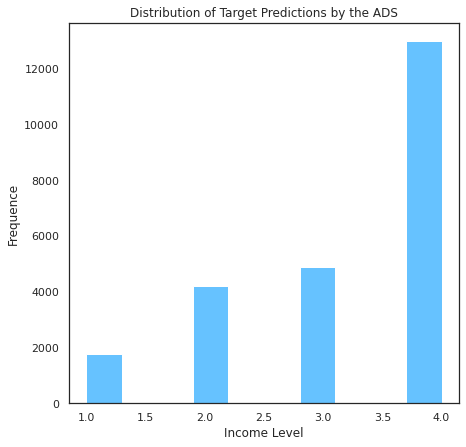

In [ ]:
# target distribution of submission, or output of model
fig, ax = plt.subplots(figsize =(7, 7))
ax.hist(submission['Target'])
plt.xlabel('Income Level')
plt.ylabel('Frequence')
plt.title('Distribution of Target Predictions by the ADS')
plt.show()

In [ ]:
submission['Target'].value_counts()

4    12993
3     4899
2     4192
1     1772
Name: Target, dtype: int64

# Implementation & Validation

In order to confirm the values found by the ADS creator, here is our own code to find the missing value counts:

In [ ]:
# returns a boolean indicating if the entire dataset includes any missing data.
print(train_set.isnull().values.any())

# returns a total count of missing values for entire dataframe
print(train_set.isnull().values.sum())

# finds which of the columns have missing values
print(train_set.columns[train_set.isnull().any()])

print(train_set['v2a1'].isnull().sum()) # num of missing values in v2al

print(train_set['v18q1'].isnull().sum()) # num of missing values in v18q1

print(train_set['rez_esc'].isnull().sum()) # num of missing values in rez_es

print(train_set['meaneduc'].isnull().sum()) # num of missing values in meaneduc

print(train_set['SQBmeaned'].isnull().sum()) # num of missing values in SQBmeaned

True
22140
Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')
6860
7342
7928
5
5


In [ ]:
# returns a boolean indicating if the entire dataset includes any missing data.
print(test_set.isnull().values.any())

# returns a total count of missing values for entire dataframe
print(test_set.isnull().values.sum())

# finds which of the columns have missing values
print(test_set.columns[test_set.isnull().any()])

print(test_set['v2a1'].isnull().sum()) # num of missing values in v2al

print(test_set['v18q1'].isnull().sum()) # num of missing values in v18q1

print(test_set['rez_esc'].isnull().sum()) # num of missing values in rez_es

print(test_set['meaneduc'].isnull().sum()) # num of missing values in meaneduc

print(test_set['SQBmeaned'].isnull().sum()) # num of missing values in SQBmeaned

True
55244
Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')
17403
18126
19653
31
31


# Outcomes

In [ ]:
# checking the how many heads of households are male and how many heads of households are female

dist_male = test_set.groupby(['parentesco1','male']).size()
dist_male

parentesco1  male
0            0       9404
             1       7118
1            0       2753
             1       4581
dtype: int64

In [ ]:
dist_female = test_set.groupby(['parentesco1','female']).size()
dist_female

parentesco1  female
0            0         7118
             1         9404
1            0         4581
             1         2753
dtype: int64

Thus, 4581 heads of household are male, and 2753 are female

This means that the model was trained on more men than women. Does the distribution of classification vary between the two genders as a result? To check this, we found and graphed the distribution of the classifications for all people, males, and females in the model output (submission)

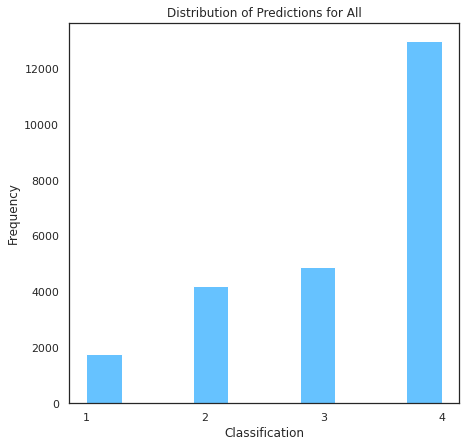

In [ ]:
# distribution of all classifications (this is the same as the distribution 
# analyzed in the Input & Output section)

fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(submission['Target'])
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions for All')
plt.xticks([1,2,3,4])
plt.show()


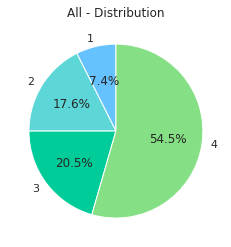

In [ ]:
counts
all = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(all, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("All - Distribution")
plt.show() 

In [ ]:
# now to find the male and female classification distribution

# first find indices of each sex
combo = pd.merge(test_set,submission, on= 'Id')

male_indices = []
female_indices = []
uhoh = []

for i in range(len(test_set['male'])):
  if test_set['male'][i] == 1:
    male_indices.append(i)
  elif test_set['female'][i] == 1:
    female_indices.append(i)
  else:
    uhoh.append(i)


In [ ]:
print(len(male_indices))
print(len(female_indices))
print(len(test_set['Id']))

11699
12157
23856


In [ ]:
# collect the classifications for each sex

male_preds = []

for i in male_indices:
  male_preds.append(combo['Target'][i])


female_preds =[]

for i in female_indices:
  female_preds.append(combo['Target'][i])

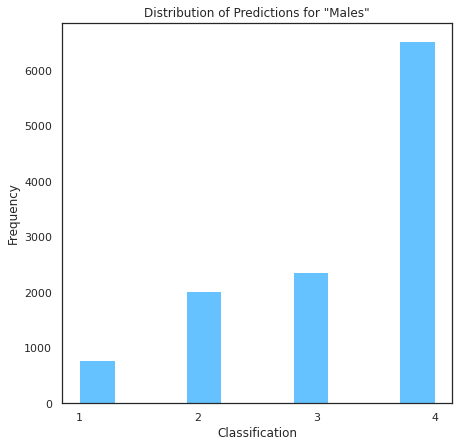

In [ ]:
# visualize male classification distribution

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(male_preds)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions for "Males"')
plt.xticks([1,2,3,4])
plt.show()


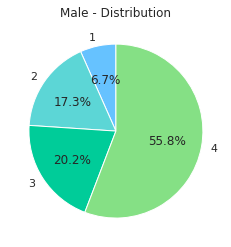

In [ ]:
male = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(male, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Male - Distribution")
plt.show() 

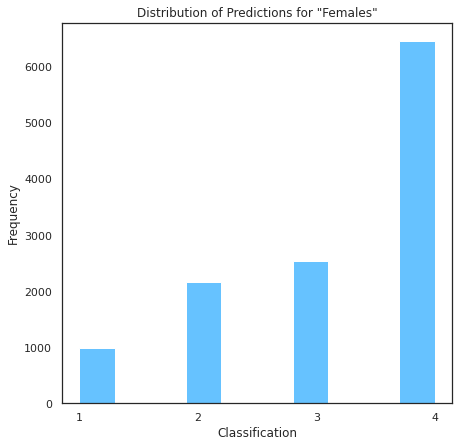

In [ ]:
# visualize female distribution

fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(female_preds)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions for "Females"')
plt.xticks([1,2,3,4])
plt.show()



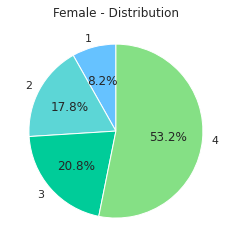

In [ ]:
female = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(female, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Female - Distribution")
plt.show() 

Since only the heads of households are used in scoring, we decided to look at the distribution breakdown of each target prediction based on if the head of household was male or female. 


In [ ]:
male_head_indices=[]
female_head_indices=[]
not_head = []

for i in range(len(test_set['parentesco1'])):
  if test_set['parentesco1'][i] == 1:
    if test_set['male'][i] == 1:
      male_head_indices.append(i)
    elif test_set['female'][i] ==1:
      female_head_indices.append(i)
  else:
      not_head.append(i)  

preds_male_head = []
for i in male_head_indices:
  preds_male_head.append(submission['Target'].iloc[i])

preds_female_head = []
for i in female_head_indices:
  preds_female_head.append(submission['Target'].iloc[i])

([<matplotlib.axis.XTick at 0x7f85908d1310>,
 <a list of 4 Text major ticklabel objects>)

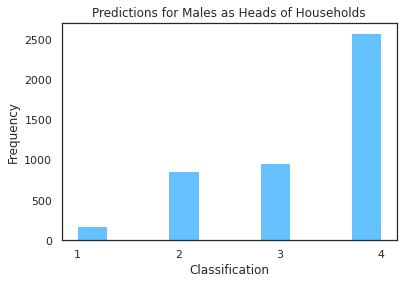

In [ ]:
counts, bins, bars = plt.hist(preds_male_head)
plt.ylabel('Frequency')
plt.title('Predictions for Males as Heads of Households')
plt.xlabel('Classification');
plt.xticks([1,2,3,4])

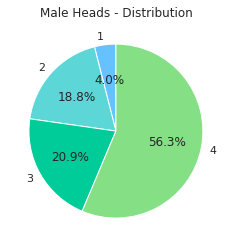

In [ ]:
male_head = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(male_head, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Male Heads - Distribution")
plt.show() 

([<matplotlib.axis.XTick at 0x7f8590ab9350>,
 <a list of 4 Text major ticklabel objects>)

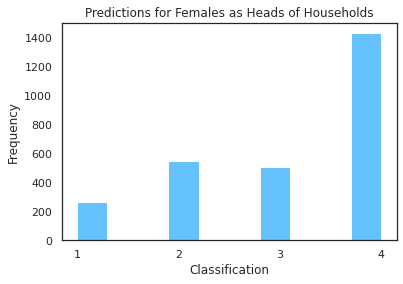

In [ ]:
counts, bins, bars = plt.hist(preds_female_head)
plt.ylabel('Frequency')
plt.title('Predictions for Females as Heads of Households')
plt.xlabel('Classification');
plt.xticks([1,2,3,4])

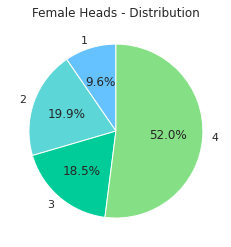

In [ ]:
female_head = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(female_head, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Female Heads - Distribution")
plt.show() 

In [ ]:
# calculating disparate impact:
# = proportion of unprivileged group that receives positive outcome / proportion of privileged group that receives positive outcome
# = proportion of females classified '4' / proportion of males classified '4'

pos_count_female = 0
for i in preds_female_head:
  if i == 4:
    pos_count_female +=1

pos_count_male = 0
for i in preds_male_head:
  if i == 4:
    pos_count_male +=1

proportion_f = pos_count_female/len(preds_female_head)
proportion_m = pos_count_male/len(preds_male_head)

print("Unprivileged: ", proportion_f, " Privileged: ", proportion_m)

disparate_impact = proportion_f/proportion_m

print(disparate_impact)

Unprivileged:  0.5201598256447512  Privileged:  0.5634141017245143
0.9232282686085257


Further exploration of fairness:
Because we do not know the true target values for the test set, we cannot calculate fairness metrics such as FPR/FNR distributions, etc. Instead, focusing on the gender subpopulations, we decided to evaluate the model's performance on 1) when the the gender assignment is shuffled and 2) when the gender distribution is switched.

In [ ]:
preprocessed_test = pd.read_csv('processed_test.csv')
preprocessed_test

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,roof_waste_material,electricity_other,head<18,adult,dependency_count,child_percent,elder_percent,adult_percent,rent_per_adult,rent_per_person,overcrowding_room_and_bedroom,no_appliances,r4h1_percent_in_male,r4m1_percent_in_female,r4h1_percent_in_total,r4m1_percent_in_total,r4t1_percent_in_total,rent_per_room,bedroom_per_room,elder_per_room,adults_per_room,child_per_room,male_per_room,female_per_room,room_per_person_household,rent_per_bedroom,edler_per_bedroom,adults_per_bedroom,child_per_bedroom,male_per_bedroom,female_per_bedroom,bedrooms_per_person_household,tablet_per_person_household,phone_per_person_household,age_12_19,escolari_age,rez_esc_escolari,rez_esc_r4t1,rez_esc_r4t2,rez_esc_r4t3,rez_esc_age,rez_esc_aggr_mean,dis_aggr_mean,male_aggr_mean,female_aggr_mean,estadocivil1_aggr_mean,estadocivil2_aggr_mean,estadocivil3_aggr_mean,estadocivil4_aggr_mean,estadocivil5_aggr_mean,estadocivil6_aggr_mean,estadocivil7_aggr_mean,parentesco2_aggr_mean,parentesco3_aggr_mean,parentesco4_aggr_mean,parentesco5_aggr_mean,parentesco6_aggr_mean,parentesco7_aggr_mean,parentesco8_aggr_mean,parentesco9_aggr_mean,parentesco10_aggr_mean,parentesco11_aggr_mean,parentesco12_aggr_mean,instlevel1_aggr_mean,instlevel2_aggr_mean,instlevel3_aggr_mean,instlevel4_aggr_mean,instlevel5_aggr_mean,instlevel6_aggr_mean,instlevel7_aggr_mean,instlevel8_aggr_mean,instlevel9_aggr_mean,escolari_mean,escolari_std,escolari_min,escolari_max,escolari_sum,age_mean,age_std,age_min,age_max,age_sum,escolari_age_mean,escolari_age_std,escolari_age_min,escolari_age_max,escolari_age_sum
0,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,0,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,3,0.5,0.0,17.0,16.50,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,0,0,2,1,0.333333,0.0,0.666667,0.0,0.0,0.0,2,0.5,0.00,0.333333,0.000000,0.333333,0.0,0.400000,0.0,0.400000,0.200000,0.400000,0.20,0.600000,0.0,0.0,1.0,0.5,1.0,0.5,1.5,0.0,0.666667,0,0.000000,0.00,0.0,0.00,0.00,0.000000,0.0,0.000000,0.666667,0.333333,0.333333,0.000000,0.666667,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.333333,0.333333,11.000000,9.539392,0,17,33,28.666667,21.361960,4,41,86,0.268293,0.232668,0.000000,0.414634,0.804878
1,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,16,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3,0.5,0.0,17.0,16.50,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,0,0,1,2,1,0.333333,0.0,0.666667,0.0,0.0,0.0,2,0.5,0.00,0.333333,0.000000,0.333333,0.0,0.400000,0.0,0.400000,0.200000,0.

In [ ]:
# create new dataframe of just the sex columns
mf = [preprocessed_test['male'], preprocessed_test['female']]
mf_df = pd.DataFrame(mf)
mf_df = mf_df.transpose()
mf_df

,male,female
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
23851,0,1
23852,1,0
23853,0,1
23854,0,1


In [ ]:
# shuffle rows
mf_df_shuffle = mf_df.sample(frac=1).reset_index(drop=True)
mf_df_shuffle

,male,female
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
...,...,...
23851,0,1
23852,0,1
23853,0,1
23854,0,1


In [ ]:
shuffle_test = preprocessed_test.copy(deep=True)
shuffle_test

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,roof_waste_material,electricity_other,head<18,adult,dependency_count,child_percent,elder_percent,adult_percent,rent_per_adult,rent_per_person,overcrowding_room_and_bedroom,no_appliances,r4h1_percent_in_male,r4m1_percent_in_female,r4h1_percent_in_total,r4m1_percent_in_total,r4t1_percent_in_total,rent_per_room,bedroom_per_room,elder_per_room,adults_per_room,child_per_room,male_per_room,female_per_room,room_per_person_household,rent_per_bedroom,edler_per_bedroom,adults_per_bedroom,child_per_bedroom,male_per_bedroom,female_per_bedroom,bedrooms_per_person_household,tablet_per_person_household,phone_per_person_household,age_12_19,escolari_age,rez_esc_escolari,rez_esc_r4t1,rez_esc_r4t2,rez_esc_r4t3,rez_esc_age,rez_esc_aggr_mean,dis_aggr_mean,male_aggr_mean,female_aggr_mean,estadocivil1_aggr_mean,estadocivil2_aggr_mean,estadocivil3_aggr_mean,estadocivil4_aggr_mean,estadocivil5_aggr_mean,estadocivil6_aggr_mean,estadocivil7_aggr_mean,parentesco2_aggr_mean,parentesco3_aggr_mean,parentesco4_aggr_mean,parentesco5_aggr_mean,parentesco6_aggr_mean,parentesco7_aggr_mean,parentesco8_aggr_mean,parentesco9_aggr_mean,parentesco10_aggr_mean,parentesco11_aggr_mean,parentesco12_aggr_mean,instlevel1_aggr_mean,instlevel2_aggr_mean,instlevel3_aggr_mean,instlevel4_aggr_mean,instlevel5_aggr_mean,instlevel6_aggr_mean,instlevel7_aggr_mean,instlevel8_aggr_mean,instlevel9_aggr_mean,escolari_mean,escolari_std,escolari_min,escolari_max,escolari_sum,age_mean,age_std,age_min,age_max,age_sum,escolari_age_mean,escolari_age_std,escolari_age_min,escolari_age_max,escolari_age_sum
0,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,0,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,3,0.5,0.0,17.0,16.50,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,0,0,2,1,0.333333,0.0,0.666667,0.0,0.0,0.0,2,0.5,0.00,0.333333,0.000000,0.333333,0.0,0.400000,0.0,0.400000,0.200000,0.400000,0.20,0.600000,0.0,0.0,1.0,0.5,1.0,0.5,1.5,0.0,0.666667,0,0.000000,0.00,0.0,0.00,0.00,0.000000,0.0,0.000000,0.666667,0.333333,0.333333,0.000000,0.666667,0.0,0.0,0.0,0.000000,0.333333,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.333333,0.333333,11.000000,9.539392,0,17,33,28.666667,21.361960,4,41,86,0.268293,0.232668,0.000000,0.414634,0.804878
1,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,16,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3,0.5,0.0,17.0,16.50,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,0,0,1,2,1,0.333333,0.0,0.666667,0.0,0.0,0.0,2,0.5,0.00,0.333333,0.000000,0.333333,0.0,0.400000,0.0,0.400000,0.200000,0.

In [ ]:
shuffle_test['male'] = mf_df_shuffle['male']
shuffle_test['female'] = mf_df_shuffle['female']

shuffle_test.to_csv('test_shuffle.csv', index=False)

In [ ]:
test_shuffle = pd.read_csv('test_shuffle.csv')

In [ ]:
# use the model to classify the test data that has shuffled gender assignments

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=400, verbose=100, eval_metric  = 'logloss',)
shuffle_pred = clf.predict(test_shuffle)

Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.92934
[200]	valid_0's multi_logloss: 0.930232
[300]	valid_0's multi_logloss: 0.963168
[400]	valid_0's multi_logloss: 1.01549
[500]	valid_0's multi_logloss: 1.0865
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.916048


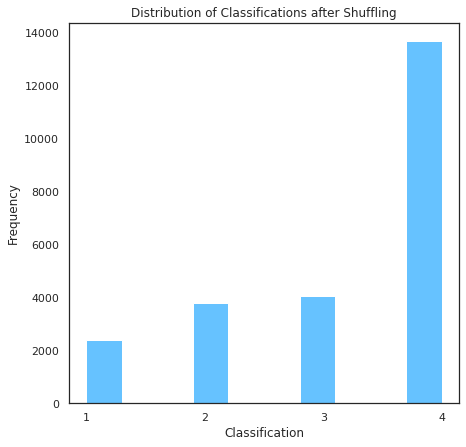

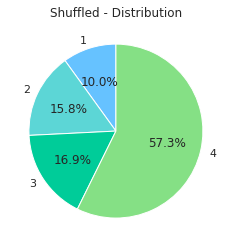

In [ ]:
fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(shuffle_pred)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Classifications after Shuffling')
plt.xticks([1,2,3,4])
plt.show()


shuffled = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(shuffled, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Shuffled - Distribution")
plt.show() 

In [ ]:
shuffled_male_indices = []
shuffled_female_indices = []
uhoh = []

for i in range(len(test_shuffle['male'])):
  if test_shuffle['male'][i] == 1:
    shuffled_male_indices.append(i)
  elif test_shuffle['female'][i] == 1:
    shuffled_female_indices.append(i)
  else:
    uhoh.append(i)

# collect the classifications for each sex

shuffled_male_preds = []

for i in shuffled_male_indices:
  shuffled_male_preds.append(shuffle_pred[i])


shuffled_female_preds =[]

for i in shuffled_female_indices:
  shuffled_female_preds.append(shuffle_pred[i])


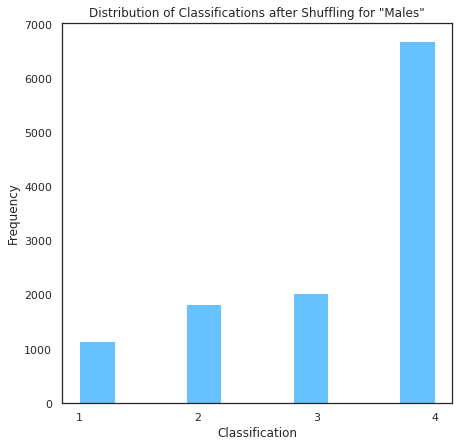

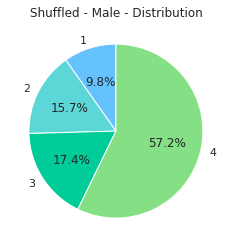

In [ ]:
# visualize male classification distribution after shuffling

fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(shuffled_male_preds)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Classifications after Shuffling for "Males"')
plt.xticks([1,2,3,4])
plt.show()


shuffled_male = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(shuffled_male, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Shuffled - Male - Distribution")
plt.show() 

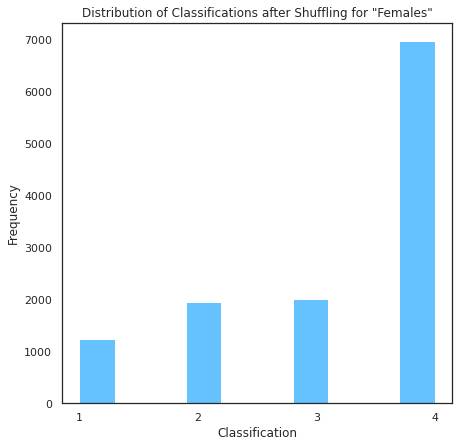

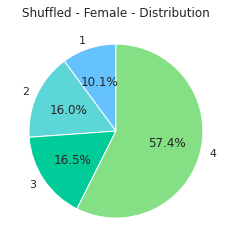

In [ ]:
# visualize female classification distribution after shuffling

fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(shuffled_female_preds)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Classifications after Shuffling for "Females"')
plt.xticks([1,2,3,4])
plt.show()


shuffled_female = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(shuffled_female, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Shuffled - Female - Distribution")
plt.show() 

Next, we switched the gender for all the rows. This was essentially assigning the male values to the female feature, and the female values to the male feature

In [ ]:
switch_test = preprocessed_test.copy(deep=True)

switch_test['male'] = preprocessed_test['female']
switch_test['female'] = preprocessed_test['male']

switch_test.to_csv('test_switch.csv', index = False)

In [ ]:
# use the model to classify the test data that has switched gender assignments

test_switch = pd.read_csv('test_switch.csv')
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=400, verbose=100, eval_metric  = 'logloss',)
switch_pred = clf.predict(test_switch)

Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.92934
[200]	valid_0's multi_logloss: 0.930232
[300]	valid_0's multi_logloss: 0.963168
[400]	valid_0's multi_logloss: 1.01549
[500]	valid_0's multi_logloss: 1.0865
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.916048


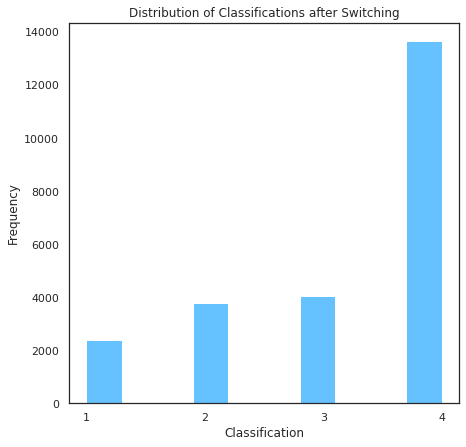

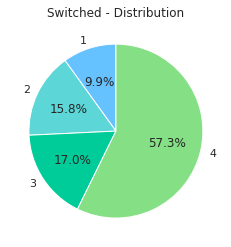

In [ ]:
fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(switch_pred)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Classifications after Switching')
plt.xticks([1,2,3,4])
plt.show()


switched = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(switched, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Switched - Distribution")
plt.show() 

In [ ]:
switched_male_indices = []
switched_female_indices = []
uhoh = []

for i in range(len(test_switch['male'])):
  if test_switch['male'][i] == 1:
    switched_male_indices.append(i)
  elif test_switch['female'][i] == 1:
    switched_female_indices.append(i)
  else:
    uhoh.append(i)

# collect the classifications for each sex

switched_male_preds = []

for i in switched_male_indices:
  switched_male_preds.append(shuffle_pred[i])


switched_female_preds =[]

for i in switched_female_indices:
  switched_female_preds.append(shuffle_pred[i])


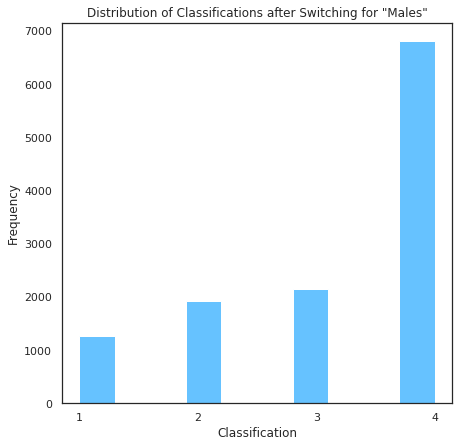

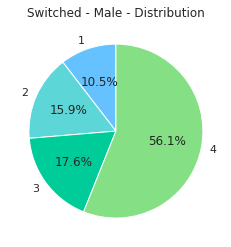

In [ ]:
# visualize male classification distribution after switching

fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(switched_male_preds)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Classifications after Switching for "Males"')
plt.xticks([1,2,3,4])
plt.show()


switched_male = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(switched_male, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Switched - Male - Distribution")
plt.show() 

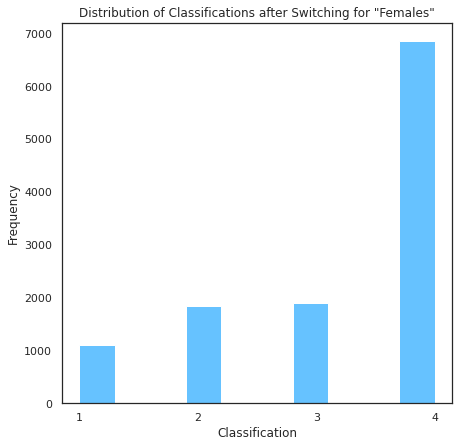

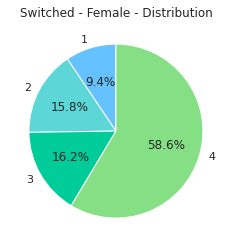

In [ ]:
# visualize female classification distribution after switching

fig,ax = plt.subplots(figsize = (7,7))
counts, bins, bars = plt.hist(switched_female_preds)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Distribution of Classifications after Switching for "Females"')
plt.xticks([1,2,3,4])
plt.show()


switched_female = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(switched_female, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Switched - Female - Distribution")
plt.show() 

We wanted to dive a little deeper here. What happens if we only switch the gender for heads of households?

In [ ]:
head_indices = []
male_heads = []
female_heads = []

for i in range(len(preprocessed_test['parentesco1'])):
  if preprocessed_test['parentesco1'][i] == 1:
    head_indices.append(i)
    if preprocessed_test['male'][i] == 1:
      male_heads.append(i)
    elif preprocessed_test['female'][i] == 1:
      female_heads.append(i)

print(len(head_indices), len(male_heads), len(female_heads))

7334 4581 2753


In [ ]:
test_head_switch = preprocessed_test.copy(deep=True)

for i in male_heads:
  test_head_switch.loc[i,'male'] = 0
  test_head_switch.loc[i,'female'] = 1

for i in female_heads:
  test_head_switch.loc[i,'male'] = 1
  test_head_switch.loc[i,'female'] = 0


In [ ]:
dist = test_head_switch.groupby(['parentesco1','male']).size()
dist # check that switch was successful

parentesco1  male
0            0       9404
             1       7118
1            0       4581
             1       2753
dtype: int64

In [ ]:
dist1 = test_head_switch.groupby(['parentesco1','female']).size()
dist1 # check that switch was successful

parentesco1  female
0            0         7118
             1         9404
1            0         2753
             1         4581
dtype: int64

In [ ]:
# save to new csv

test_head_switch.to_csv('test_head_switch.csv', index=False)
test_head_switch = pd.read_csv('test_switch.csv')

# run model

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=400, verbose=100, eval_metric  = 'logloss',)
head_switch_pred = clf.predict(test_head_switch)


Training until validation scores don't improve for 400 rounds.
[100]	valid_0's multi_logloss: 0.92934
[200]	valid_0's multi_logloss: 0.930232
[300]	valid_0's multi_logloss: 0.963168
[400]	valid_0's multi_logloss: 1.01549
[500]	valid_0's multi_logloss: 1.0865
Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.916048


In [ ]:
switched_male_head_indices=[]
switched_female_head_indices=[]
switched_not_head = []

for i in range(len(test_head_switch['parentesco1'])):
  if test_head_switch['parentesco1'][i] == 1:
    if test_head_switch['male'][i] == 1:
      #print('male head',i)
      switched_male_head_indices.append(i)
    elif test_head_switch['female'][i] ==1:
      #print('female head')
      switched_female_head_indices.append(i)
  else:
      not_head.append(i)  

switched_preds_male_head = []
for i in switched_male_head_indices:
  switched_preds_male_head.append(head_switch_pred[i])

switched_preds_female_head = []
for i in switched_female_head_indices:
  switched_preds_female_head.append(head_switch_pred[i])

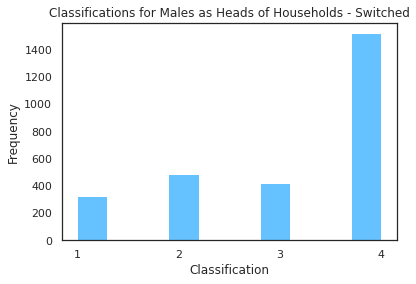

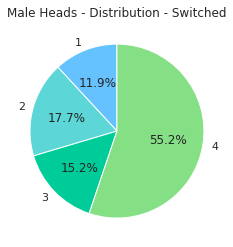

In [ ]:
counts, bins, bars = plt.hist(switched_preds_male_head)
plt.ylabel('Frequency')
plt.title('Classifications for Males as Heads of Households - Switched')
plt.xlabel('Classification');
plt.xticks([1,2,3,4])
plt.show()


male_head_switch = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(male_head_switch, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Male Heads - Distribution - Switched")
plt.show() 

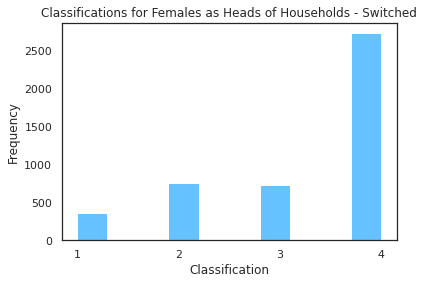

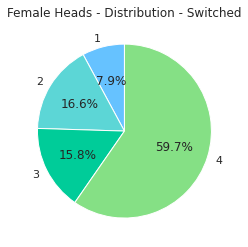

In [ ]:
counts, bins, bars = plt.hist(switched_preds_female_head)
plt.ylabel('Frequency')
plt.title('Classifications for Females as Heads of Households - Switched')
plt.xlabel('Classification');
plt.xticks([1,2,3,4])
plt.show()


female_head_switch = np.array([counts[0],counts[3], counts[6], counts[9]])
mylabels = ["1", "2", "3", "4"]

plt.pie(female_head_switch, labels = mylabels, startangle = 90,autopct='%1.1f%%')
plt.title("Female Heads - Distribution - Switched")
plt.show() 

In [ ]:
# approximating disparate impact from the above pie charts

switched_heads_di = .613/.562
switched_heads_di

1.090747330960854

We now want to assess the stability and robustness of the ADS by using LIME to explain the model. 

In [ ]:
pip install lime


     |████████████████████████████████| 275 kB 20.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=89e08bdf593039097365cb86384af4b36aeb951efec5a26f9ebe72976c0b3b2b
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular
from lime import submodular_pick
import sklearn

In [ ]:
# Get a list of feature names (excluding the outcome variable)
feature_names = train.columns[:]

In [ ]:
# Mark labels and encode them using sklearn
le = sklearn.preprocessing.LabelEncoder()
labels = [1,2,3,4]
le.fit(labels)
labels = le.transform(labels)
#print(le.classes_)
class_names = le.classes_
#class_names = class_names[0]
data = train_set.iloc[:,:-1]
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)

Class names:  [1 2 3 4]
Label mapping:  {1: 0, 2: 1, 3: 2, 4: 3}


In [ ]:
feature_names

Index(['v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'v18q1',
       'r4h1', 'r4h2',
       ...
       'age_mean', 'age_std', 'age_min', 'age_max', 'age_sum',
       'escolari_age_mean', 'escolari_age_std', 'escolari_age_min',
       'escolari_age_max', 'escolari_age_sum'],
      dtype='object', length=216)

In [ ]:
train = train[np.all(np.isfinite(train), axis=1)]

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train.values, 
                                                   feature_names=feature_names,
                                                   class_names=class_names)
                                              

In [ ]:
predict_fn = lambda x: clf.predict_proba(x)
predict_fn

<function __main__.<lambda>>

In [ ]:
i = 179
# Get explanation
exp = explainer.explain_instance((test.values[i]), predict_fn, num_features=5)
print(submission['Target'][i])

2


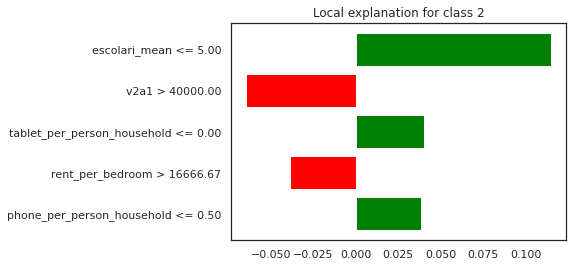

In [ ]:
# Visualize the explanation 
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(show_all=True)

In [ ]:
# Initialize the SP object
sp_obj = submodular_pick.SubmodularPick(explainer, train.values, predict_fn, method='sample', sample_size=500, 
                                        num_features=5, num_exps_desired=5)

In [ ]:
sp_obj.V

In [ ]:
for ind in sp_obj.V:
    exp = explainer.explain_instance(test.values[ind], predict_fn, num_features=5)
    exp.show_in_notebook(show_all=False)
    print("==========================")